# Volatility Forecasting Using Advanced Neural Networks 
**Towards Anticipative Vega Hedging**

---

## Context

In the previous notebooks, we built an end-to-end directional trading pipeline using SP500 log-returns as our base signal.  
So far, the strategy integrates:
- A directional **LSTM classifier** for T+1 market movement.
- Two **Autoencoders (AE)** designed to detect market regimes (bull/bear) based on reconstruction errors.
- A filtering logic coupling directional signals with regime classification to enhance precision.

While this hybrid structure already improves signal quality, it lacks an explicit treatment of **volatility**, a key variable in risk-adjusted sizing and options-related strategies.

---

##  Objective of this Notebook

The main goal of this notebook is to **introduce volatility awareness** into our framework, by forecasting **future volatility at T+1** using a **Variational Autoencoder (VAE)**.

This new module is not necessarily meant to be integrated into the existing directional strategy right away. Instead, we aim to:
- Explore whether volatility can be meaningfully **anticipated**, rather than inferred from past realized values or implied metrics (e.g., VIX).
- Provide a foundation for **vega-aware strategies** (e.g., adjusting exposure ahead of high-volatility periods).
- Deepen our understanding of **probabilistic latent modeling** in a financial context.

---

##  Dataset & Scope

We will use the **SP500 daily log-returns**, scaled and cleaned as in Project.  
Additional features or targets such as **realized volatility** or **VIX** may be introduced during model construction.

This notebook is not focused on short-term profit optimization, but rather on **quantitative research**, model building, and volatility modeling capacity in a financial time series context.

---

##  Table of Contents

### **Part I Volatility Forecasting with VAE-LSTM**

**1. Preparing the Data**  
&emsp; Construction of volatility targets (e.g., rolling std), input features and sequences.  
&emsp; Scaling, sequencing and visualization.

**2. Theoretical Foundations of the Variational Autoencoder**  
&emsp; Probabilistic modeling, latent spaces, reparametrization, KL divergence, and training objectives.  
&emsp; Discussion of how the VAE is adapted for volatility estimation.

**3. VAE Implementation in PyTorch**  
&emsp; Encoder, decoder, latent sampling.  
&emsp; Custom loss function combining reconstruction and KL divergence.

**4. Training the Model**  
&emsp; Training loop, monitoring of convergence, loss curves, and early stopping.  
&emsp; Latent space visualization.

**5. Forecasting Volatility at T+1**  
&emsp; Extracting predicted volatility from the latent structure.  
&emsp; Comparing with realized volatility metrics.  
&emsp; Correlation, error metrics and regime-based evaluation.

**6. Discussion & Next Steps**  
&emsp; Strengths and limitations of the VAE for volatility modeling.  
&emsp; Potential integration into position sizing or volatility filters.  
&emsp; Possible extensions (CVAE, attention-based VAE, diffusion models).

### **Part II Volatility Forecasting with VAE-GRU**

**1. Data Reconfiguration**  
&emsp; Define new input/output pairs aligned with forecasting volatility directly at T+1 or T+3.

**2. GRU-based VAE Model**  
&emsp; Build and explain the architecture: GRU encoder + regressor decoder.

**3. Training Setup**  
&emsp; Train on historical sequences using KL-regularized MSE loss.

**4. Evaluation**  
&emsp; Compare predictions with realized volatility using correlation, normalized RMSE, and directional accuracy.

**5. Direction-Aware GRU-VAE: Loss Enhancement**  
&emsp; Visualize the latent space and interpret market regimes or transitions.

**6. Fourier Loss Integration in VAE-GRU** 

### **Part III Volatility Forecasting with Transformer-MLP**

**1. Model Architecture: Transformer for Volatility Forecasting**  
&emsp; Transformer Encoder Layer
&emsp; Temporal Pooling
&emsp; Prediction Head (MLP)

**2. Transformer with fourrier featured loss**  
&emsp; Combination of signal spectrum dynamics (Fourier) and detected peak amplitude     

**3. Transformer with sinusoïdale positional encoding**  
&emsp; Addition of sinusoidal positional encoder 


---

Let’s begin with data preparation for volatility estimation.


## 1. Preparing the Data  
To train a Variational Autoencoder (VAE) to forecast volatility at T+1, we need to clearly define:

- The **input features**: historical log returns over a fixed window (e.g., 20 days),
- The **target variable**: a proxy for realized volatility in the near future.
---
### Defining the Volatility Target

We define **realized volatility at time $t+1$** as the standard deviation of log-returns over a short forward-looking horizon:

$$
\text{RealizedVol}_{t+1} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( r_{t+i} - \bar{r} \right)^2}
$$

with:
- $r_t$: the daily log-return at time $t$,
- $N$: the size of the future window (typically 3),
- $\bar{r}$: the mean return over the window.

This target is **shifted** to time $t$, so we can learn to forecast it using only information available up to $t$.

---

### Feature Engineering for Volatility Modeling

In order to enhance the model’s ability to forecast volatility, we introduce several additional features derived from the log returns.

These features are engineered to capture various aspects of price behavior, such as sudden changes, regime shifts, or amplitude of market fluctuations.

---

#### 1. Absolute Return

The absolute return at time $t$ is defined as:

$$
\text{AbsRet}_t = |r_t|
$$

It acts as a proxy for local volatility and helps the model identify turbulence zones.

---

#### 2. Realized Volatility over Different Windows

We compute the backward-looking realized volatility over multiple windows:

$$
\text{RealizedVol}_t^{(n)} = \sqrt{\frac{1}{n} \sum_{i=0}^{n-1} (r_{t-i} - \bar{r})^2}
$$

We include 3 versions:
- Short-term: $n = 5$
- Medium-term: $n = 10$
- Long-term: $n = 20$

---

#### 3. Historical Return Range

To capture the price movement span over a window:

$$
\text{Range}_t = \max(r_{t-n:t}) - \min(r_{t-n:t})
$$

It reflects compression vs expansion patterns in market dynamics.

All these engineered features are concatenated to the original input sequence to enrich the temporal context provided to the VAE.


---
###  Scaling

Both the input sequences $X_t$ and the target volatility values are scaled to $[0,1]$ using MinMax scaling for stable training and to ensure the decoder output stays in a meaningful range.

We also visualize the target volatility series to ensure the presence of variability, outliers, and regime changes, which will be crucial for training a generative model such as the VAE.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Volatility target (T+1): realized volatility over next 3 hours
df = pd.read_csv("../data/Cleaned_data.csv", index_col=0)
pd.set_option('display.max_columns', None)

returns = df["SP500_LogRet_Scaled"].dropna()

window_size = 3
realized_vol = returns.rolling(window=window_size).std()
vol_target = realized_vol.shift(-1).dropna()  # this is our y_t+1

# Re-align dataset to keep only overlapping indices
df = df.loc[vol_target.index]



In [4]:
# Feature Engineering (from returns and context)
df["AbsRet"] = returns.abs()
df["RealizedVol_5"] = returns.rolling(window=5).std()
df["RealizedVol_10"] = returns.rolling(window=10).std()
df["RealizedVol_20"] = returns.rolling(window=20).std()
df["ReturnRange_10"] = returns.rolling(window=10).apply(lambda x: x.max() - x.min(), raw=True)

# Drop NaNs introduced by rolling
df.dropna(inplace=True)

# Final feature selection for input X_t
feature_cols = [
    "SP500_LogRet_Scaled",
    "AbsRet",
    "RealizedVol_5",
    "RealizedVol_10",
    "RealizedVol_20",
    "ReturnRange_10",
    'volatility_direction',
    "VIX_Close_Scaled"  # contextual implied volatility
]


In [5]:
# Create time windows (sliding sequences of length n)

# Re-check only valid features in df
feature_cols = [col for col in feature_cols if col in df.columns]
features = df[feature_cols]

# Re-align with target once more (defensive step)
common_index = features.index.intersection(vol_target.index)
features = features.loc[common_index]
vol_target = vol_target.loc[common_index]
sequence_length = 20
X_seq = []
y_seq = []

for i in range(sequence_length, len(features)):
    X_seq.append(features.iloc[i-sequence_length:i].values)
    y_seq.append(vol_target.iloc[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq).reshape(-1, 1)

print("Input sequences shape:", X_seq.shape)
print("Target volatility shape:", y_seq.shape)


Input sequences shape: (3699, 20, 8)
Target volatility shape: (3699, 1)


Scaled input shape: (3699, 20, 8)
Scaled target shape: (3699, 1)


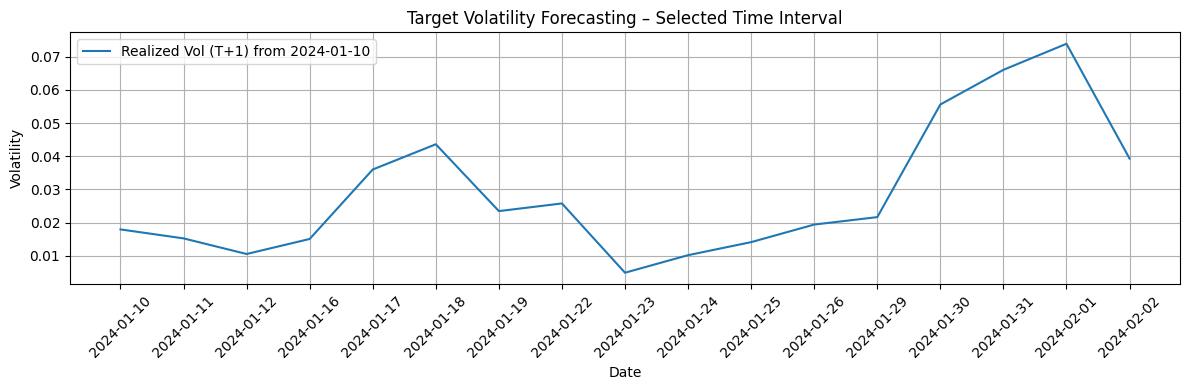

In [6]:
# Scale input and output
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq.shape)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_seq)

print("Scaled input shape:", X_scaled.shape)
print("Scaled target shape:", y_scaled.shape)

# Plot volatility target 


start_date = "2024-01-10"   # Change this as needed
end_date = "2024-02-03"     

if end_date:
    vol_sample = vol_target.loc[start_date:end_date]
else:
    vol_sample = vol_target.loc[start_date:]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(vol_sample, label=f"Realized Vol (T+1) from {start_date}")
plt.title("Target Volatility Forecasting – Selected Time Interval")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True)
plt.tight_layout()       
plt.show()



---
## 2. Theoretical Foundations of the Variational Autoencoder (VAE)

The Variational Autoencoder (VAE) is a generative model that extends the classical autoencoder by adopting a **probabilistic approach** to representation learning.  
Instead of mapping an input to a fixed code (latent vector), the VAE learns to map it to a **distribution over latent variables**, from which we can sample.



### Intuition

In a classical autoencoder:

- The encoder maps input $x$ to a deterministic latent vector $z$
- The decoder reconstructs the input: $\hat{x} = f(z)$

In a **VAE**:

- The encoder maps input $x$ to a **distribution over** $z$ (typically Gaussian)
- We sample $z \sim q_\phi(z \mid x)$ and decode: $\hat{x} \sim p_\theta(x \mid z)$

The idea is to **regularize the latent space** to follow a known prior (usually $\mathcal{N}(0, I)$), enabling generation and interpolation.

---

### Mathematical Formulation

Let:
- $x \in \mathbb{R}^d$ be the input (e.g., a sequence of market features)
- $z \in \mathbb{R}^k$ be the latent vector
- $q_\phi(z \mid x)$ be the encoder (approximate posterior)
- $p_\theta(x \mid z)$ be the decoder (likelihood)
- $p(z) = \mathcal{N}(0, I)$ be the prior over the latent space

Then the model is trained to **maximize the Evidence Lower Bound (ELBO)**:

$$
\log p(x) \geq \mathbb{E}_{q_\phi(z \mid x)} [\log p_\theta(x \mid z)] - D_{KL}(q_\phi(z \mid x) \parallel p(z))
$$

This decomposes into:
- A **reconstruction term**: encourages $\hat{x} \approx x$
- A **KL divergence**: encourages $q_\phi(z \mid x)$ to be close to $\mathcal{N}(0, I)$

---

### Reparameterization Trick

To make $z \sim q_\phi(z \mid x)$ differentiable, we use:

$$
z = \mu(x) + \sigma(x) \odot \epsilon,\quad \epsilon \sim \mathcal{N}(0, I)
$$

This allows gradients to flow through the encoder during backpropagation.

---

### Final Loss Function

The training loss is:

$$
\mathcal{L}_{\text{VAE}}(x) = \underbrace{\|x - \hat{x}\|^2}_{\text{Reconstruction Loss}} + \beta \cdot \underbrace{D_{KL}\left(q_\phi(z \mid x) \parallel \mathcal{N}(0, I)\right)}_{\text{Latent Regularization}}
$$

The coefficient $\beta$ controls the trade-off between **fidelity** and **generativity** (β-VAE formulation).

---

### Application to Volatility Estimation

In our case:

- $x$ is a **sequence of market features** (log returns, realized vol, VIX…)
- $\hat{x}$ is the reconstructed sequence
- But the true interest lies in the **latent space**: we want $z$ to encode **volatility patterns**
- Optionally, we can add a **volatility head** that maps $z$ directly to a prediction of volatility at $T+1$

Thus, the VAE becomes a tool to:
- Compress market context into a **probabilistic latent code**
- Capture **hidden regimes** or structure in volatility dynamics
- Generate forecasts based on a compact, regularized representation

---

In the next section, we will implement a `VolatilityVAE` architecture in PyTorch, consisting of:
- An encoder mapping sequences to $(\mu, \log\sigma^2)$
- A reparameterized latent sampling layer
- A decoder reconstructing the input
- A loss function combining MSE and KL divergence


---
## 3. VAE Implementation in PyTorch  
In this section, we implement two versions of the Variational Autoencoder (VAE) adapted to our volatility forecasting task.  
Both models share the same underlying principle: learn a compact latent representation of the market context, and leverage it to reconstruct inputs or predict volatility-related patterns.

We distinguish two architectures:



### 3.1 VolatilityVAE_Flat

This version treats the input time series sequence as a flat vector:

- The encoder flattens the input sequence and passes it through feedforward layers
- The latent space is sampled via the reparameterization trick
- The decoder reconstructs the entire input sequence
- The loss combines:
  - Mean squared error between the input and its reconstruction
  - KL divergence between the learned latent distribution and a standard normal prior

This model is effective for **dimensionality reduction, clustering**, and visualizing latent volatility regimes.



### 3.2 VolatilityVAE_LSTM

This variant preserves the temporal structure of the input:

- The encoder is an LSTM that processes each time step and returns a hidden summary
- The latent space is sampled from the LSTM's final hidden state
- The decoder is another LSTM that reconstructs the input sequence
- Alternatively, the decoder can predict just the volatility at T+1 from the latent vector (optional)
- The loss remains a combination of reconstruction loss + KL divergence

This model is better suited for capturing **temporal dependencies and dynamic patterns** in volatility evolution.



### Shared Training Data

Both models will be trained on the same dataset:
- `X_scaled`: input sequences of shape `(n_samples, seq_len, n_features)`
- `y_scaled`: target volatility at T+1 (optionally used for supervision)

In both cases, we will compare:
- The quality of reconstruction
- The structure of the learned latent space
- The model's ability to reflect and forecast volatility patterns

---

### 3.1 VolatilityVAE_Flat

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VolatilityVAE_Flat(nn.Module):
    def __init__(self, input_dim, seq_len, latent_dim=10, hidden_dim=64, beta=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.beta = beta

        #  Encoder 
        self.encoder = nn.Sequential(
            nn.Flatten(),  # from (batch, seq_len, input_dim) → (batch, seq_len * input_dim)
            nn.Linear(seq_len * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        #  Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * input_dim),
            nn.Sigmoid()  # use sigmoid if input data is scaled to [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        recon_flat = self.decoder(z)
        return recon_flat.view(-1, self.seq_len, self.input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

    def compute_loss(self, x, recon, mu, logvar):
        recon_loss = F.mse_loss(recon, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + self.beta * kl_loss
        return total_loss, recon_loss, kl_loss


### 3.2 VolatilityVAE_LSTM

In [8]:
class VolatilityVAE_LSTM(nn.Module):
    def __init__(self, input_dim, seq_len, latent_dim=10, hidden_dim=64, beta=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.beta = beta

        #  Encoder: LSTM → (mu, logvar)
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        #  Decoder: latent z → initial hidden state → reconstructed sequence
        self.decoder_init = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)  # h_n: (1, batch, hidden_dim)
        h_n = h_n.squeeze(0)
        mu = self.mu_layer(h_n)
        logvar = self.logvar_layer(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len=None):
        if seq_len is None:
            seq_len = self.seq_len

        batch_size = z.size(0)
        h_0 = torch.tanh(self.decoder_init(z)).unsqueeze(0)  # (1, batch, hidden_dim)
        c_0 = torch.zeros_like(h_0)

        # Feed zeros as inputs for decoding (teacher forcing can be added later)
        decoder_input = torch.zeros((batch_size, seq_len, self.input_dim), device=z.device)
        decoder_output, _ = self.decoder_lstm(decoder_input, (h_0, c_0))
        recon = self.output_layer(decoder_output)
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, seq_len=self.seq_len)
        return recon, mu, logvar

    def compute_loss(self, x, recon, mu, logvar):
        recon_loss = F.mse_loss(recon, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + self.beta * kl_loss
        return total_loss, recon_loss, kl_loss


---

### 4 Train/Test Split for Time Series

Before training our VAE models, we split the dataset into a **training and test set**.

Since we are working with time series, we apply a **chronological split** without shuffling:
- The first 80% of samples are used for training
- The remaining 20% for testing

This setup ensures that the model only learns from past data, respecting the temporal order.

---


In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Define split index
split_ratio = 0.8
split_idx = int(len(X_tensor) * split_ratio)

# Chronological split (no shuffle)
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

# Wrap into datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train set shape:", X_train.shape)
print("Test set shape :", X_test.shape)


Train set shape: torch.Size([2959, 20, 8])
Test set shape : torch.Size([740, 20, 8])


## 5. Training the Model

We now proceed to train the VAE models introduced earlier using the prepared train/test split.

The training loop is structured to:
- Optimize the total loss, which combines reconstruction accuracy and KL regularization
- Monitor convergence over epochs for both train and test sets
- Extract and visualize the learned latent representations $z$

We use:
- A batch size of 64
- The Adam optimizer
- A learning rate of 1e-3
- No shuffling to preserve time order


In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_vae(model, train_loader, test_loader, 
              n_epochs=50, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_recons, val_recons = [], []
    train_kls, val_kls = [], []

    for epoch in range(n_epochs):
        model.train()
        total_loss, recon_loss, kl_loss = 0, 0, 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            recon, mu, logvar = model(x_batch)
            loss, recon_l, kl_l = model.compute_loss(x_batch, recon, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_loss += recon_l.item()
            kl_loss += kl_l.item()

        # Average per epoch
        total_loss /= len(train_loader)
        recon_loss /= len(train_loader)
        kl_loss /= len(train_loader)

        train_losses.append(total_loss)
        train_recons.append(recon_loss)
        train_kls.append(kl_loss)

        #  Evaluation on test set
        model.eval()
        with torch.no_grad():
            val_loss, val_recon, val_kl = 0, 0, 0
            for x_batch, _ in test_loader:
                x_batch = x_batch.to(device)
                recon, mu, logvar = model(x_batch)
                loss, recon_l, kl_l = model.compute_loss(x_batch, recon, mu, logvar)
                val_loss += loss.item()
                val_recon += recon_l.item()
                val_kl += kl_l.item()

            val_loss /= len(test_loader)
            val_recon /= len(test_loader)
            val_kl /= len(test_loader)

            val_losses.append(val_loss)
            val_recons.append(val_recon)
            val_kls.append(val_kl)

        # Logging
        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {total_loss:.4f} (Recon: {recon_loss:.4f}, KL: {kl_loss:.4f}) | "
              f"Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_recon": train_recons,
        "val_recon": val_recons,
        "train_kl": train_kls,
        "val_kl": val_kls,
    }


#### Convergence curves

In [11]:
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 4))

    # Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Reconstruction
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_recon"], label="Train")
    plt.plot(epochs, history["val_recon"], label="Val")
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # KL Divergence
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_kl"], label="Train")
    plt.plot(epochs, history["val_kl"], label="Val")
    plt.title("KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("KL")
    plt.legend()

    plt.tight_layout()
    plt.show()

def compare_training_losses(flat_hist, lstm_hist):
    epochs = range(1, len(flat_hist["train_loss"]) + 1)

    plt.figure(figsize=(15, 4))

    # Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, flat_hist["val_loss"], label="Flat VAE", color='blue')
    plt.plot(epochs, lstm_hist["val_loss"], label="LSTM VAE", color='purple')
    plt.title("Validation – Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Reconstruction
    plt.subplot(1, 3, 2)
    plt.plot(epochs, flat_hist["val_recon"], label="Flat VAE", color='blue')
    plt.plot(epochs, lstm_hist["val_recon"], label="LSTM VAE", color='purple')
    plt.title("Validation – Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # KL Divergence
    plt.subplot(1, 3, 3)
    plt.plot(epochs, flat_hist["val_kl"], label="Flat VAE", color='blue')
    plt.plot(epochs, lstm_hist["val_kl"], label="LSTM VAE", color='purple')
    plt.title("Validation – KL Divergence")
    plt.xlabel("Epoch")
    plt.ylabel("KL")
    plt.legend()

    plt.tight_layout()
    plt.show()



### First training session

In [12]:
#  Common training params
params = {
    "input_dim": X_scaled.shape[2],
    "seq_len": X_scaled.shape[1],
    "latent_dim": 10,
    "hidden_dim": 64,
    "beta": 0.2,
    "n_epochs": 50,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

params

{'input_dim': 8,
 'seq_len': 20,
 'latent_dim': 10,
 'hidden_dim': 64,
 'beta': 0.2,
 'n_epochs': 50,
 'lr': 0.001,
 'device': 'cpu'}

In [ ]:


#  Train Flat VAE
print(" Training VolatilityVAE_Flat...\n")
vae_flat = VolatilityVAE_Flat(
    input_dim=params["input_dim"],
    seq_len=params["seq_len"],
    latent_dim=params["latent_dim"],
    hidden_dim=params["hidden_dim"],
    beta=params["beta"]
)

flat_history = train_vae(
    vae_flat,
    train_loader,
    test_loader,
    n_epochs=params["n_epochs"],
    lr=params["lr"],
    device=params["device"]
)

#  Train LSTM VAE
print("\n Training VolatilityVAE_LSTM...\n")
vae_lstm = VolatilityVAE_LSTM(
    input_dim=params["input_dim"],
    seq_len=params["seq_len"],
    latent_dim=params["latent_dim"],
    hidden_dim=params["hidden_dim"],
    beta=params["beta"]
)

lstm_history = train_vae(
    vae_lstm,
    train_loader,
    test_loader,
    n_epochs=params["n_epochs"],
    lr=params["lr"],
    device=params["device"]
)


 Training VolatilityVAE_Flat...

Epoch 1/50 | Train Loss: 0.0954 (Recon: 0.0944, KL: 0.0047) | Val Loss: 0.0554 (Recon: 0.0547, KL: 0.0032)
Epoch 2/50 | Train Loss: 0.0498 (Recon: 0.0490, KL: 0.0043) | Val Loss: 0.0387 (Recon: 0.0384, KL: 0.0012)
Epoch 3/50 | Train Loss: 0.0406 (Recon: 0.0404, KL: 0.0010) | Val Loss: 0.0361 (Recon: 0.0360, KL: 0.0003)
Epoch 4/50 | Train Loss: 0.0390 (Recon: 0.0389, KL: 0.0006) | Val Loss: 0.0357 (Recon: 0.0356, KL: 0.0006)
Epoch 5/50 | Train Loss: 0.0384 (Recon: 0.0383, KL: 0.0007) | Val Loss: 0.0355 (Recon: 0.0353, KL: 0.0010)
Epoch 6/50 | Train Loss: 0.0381 (Recon: 0.0380, KL: 0.0009) | Val Loss: 0.0354 (Recon: 0.0352, KL: 0.0010)
Epoch 7/50 | Train Loss: 0.0382 (Recon: 0.0380, KL: 0.0010) | Val Loss: 0.0353 (Recon: 0.0351, KL: 0.0008)
Epoch 8/50 | Train Loss: 0.0380 (Recon: 0.0378, KL: 0.0010) | Val Loss: 0.0354 (Recon: 0.0352, KL: 0.0010)
Epoch 9/50 | Train Loss: 0.0380 (Recon: 0.0378, KL: 0.0012) | Val Loss: 0.0353 (Recon: 0.0351, KL: 0.0008)
Epoc

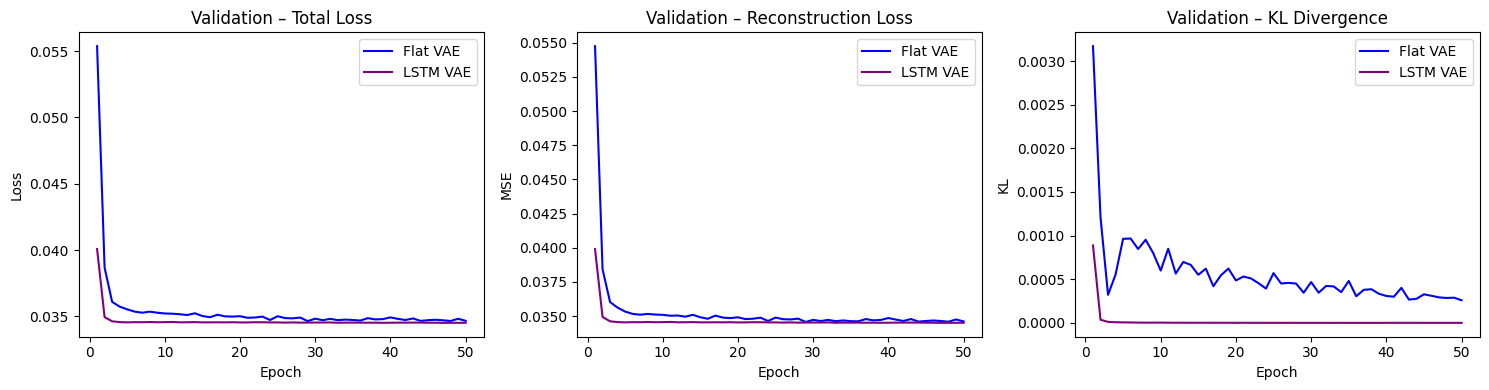

In [14]:
compare_training_losses(flat_history, lstm_history)

### 5 Forecasting Volatility at T+1

Now that our Variational Autoencoders (VAE) — both **Flat** and **LSTM-based** — have been trained to extract meaningful latent representations of past market dynamics, we move to the **final predictive step** of our modeling pipeline:

> Can the latent code **`z`**, sampled from past market conditions, help us predict the **realized volatility at T+1**?

This section focuses on building a **regression head** that maps the learned latent vector `z` to the target volatility. The idea is to treat the encoder part of the VAE as a **feature extractor**, and add a supervised module trained to minimize the error between predicted and actual volatility.

---

#### What we'll do:

1. **Freeze the trained VAE encoder** and extract latent vectors `z` for all sequences.
2. Build a lightweight regression head `z → 𝑣𝑜𝑙(T+1)`, trained on the same train/test split.
3. Evaluate the prediction:
   - Mean Squared Error (MSE), Mean Absolute Error (MAE)
   - Pearson Correlation (ρ)
   - Visual comparison between predicted and realized volatility
4. Optionally, break down results by **market regime** (Bull/Bear), as detected in Notebook 03.

---

This stage bridges the gap between **unsupervised latent learning** and **supervised forecasting**, allowing us to **quantify how much predictive signal** the VAE has retained from the historical data.


#### **5.1 Training z → vol(T+1)**

We train a simple MLP head on the latent variables extracted from each model (FlatVAE and LSTMVAE):

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

#  Define a small regression head
class LatentToVol(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, z):
        return self.model(z)

#  Helper function to extract z for a given model and dataset
def extract_latents(vae_model, data_loader, device):
    vae_model.eval()
    zs = []
    ys = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            mu, _ = vae_model.encode(x_batch)
            zs.append(mu.cpu())
            ys.append(y_batch)
    return torch.cat(zs), torch.cat(ys)

#  Training function for z → vol(T+1)
def train_latent_regressor(z, y, latent_dim, n_epochs=100, lr=1e-3):
    model = LatentToVol(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(z)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

    return model


#### **5.2 Performance evaluation**

After training, we predict on the test set and calculate several metrics + display:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch

def evaluate_latent_regressor(model, z_test, y_test, title="Forecast vs Realized Volatility"):
    model.eval()
    with torch.no_grad():
        preds = model(z_test).squeeze().numpy()
        true = y_test.squeeze().numpy()

    #  METRICS  #
    rmse = np.sqrt(np.mean((true - preds) ** 2))
    nrmse = rmse / np.std(true)
    corr, _ = pearsonr(true, preds)

    true_diff = np.diff(true)
    pred_diff = np.diff(preds)
    correct_direction = np.sign(true_diff) == np.sign(pred_diff)
    direction_acc = np.mean(correct_direction)

    #  PRINT  #
    print(f" Normalized RMSE: {nrmse:.5f}")
    print(f" Pearson Correlation: {corr:.4f}")
    print(f" Directional Accuracy: {direction_acc*100:.2f}%")

    #  PLOT 1: Forecast vs Realized  #
    plt.figure(figsize=(14, 5))
    plt.plot(true[-300:], label="Realized Vol (T+1)", linewidth=2)
    plt.plot(preds[-300:], label="Predicted Vol (T+1)", linewidth=2, linestyle='--')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Scaled Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  PLOT 2:  Volatility  #
    plt.figure(figsize=(14, 4))
    plt.plot(true_diff[-299:], label="Δ Realized Vol", color="blue")
    plt.plot(pred_diff[-299:], label="Δ Predicted Vol", color="orange")
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Volatility Variation Forecast (Δ t+1)")
    plt.xlabel("Time")
    plt.ylabel("Δ Scaled Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### **5.3 Evaluation of mdoel**

MPL testing on latent space flat and LSTM 

[Epoch 0] Loss: 0.00566
[Epoch 10] Loss: 0.00330
[Epoch 20] Loss: 0.00267
[Epoch 30] Loss: 0.00270
[Epoch 40] Loss: 0.00268
[Epoch 50] Loss: 0.00264
[Epoch 60] Loss: 0.00264
[Epoch 70] Loss: 0.00263
[Epoch 80] Loss: 0.00262
[Epoch 90] Loss: 0.00261
[Epoch 0] Loss: 0.01083
[Epoch 10] Loss: 0.00606
[Epoch 20] Loss: 0.00357
[Epoch 30] Loss: 0.00276
[Epoch 40] Loss: 0.00269
[Epoch 50] Loss: 0.00272
[Epoch 60] Loss: 0.00270
[Epoch 70] Loss: 0.00268
[Epoch 80] Loss: 0.00268
[Epoch 90] Loss: 0.00268
📉 Normalized RMSE:       0.98350
🔗 Pearson Correlation:  0.4748
🔼 Directional Accuracy: 51.56%


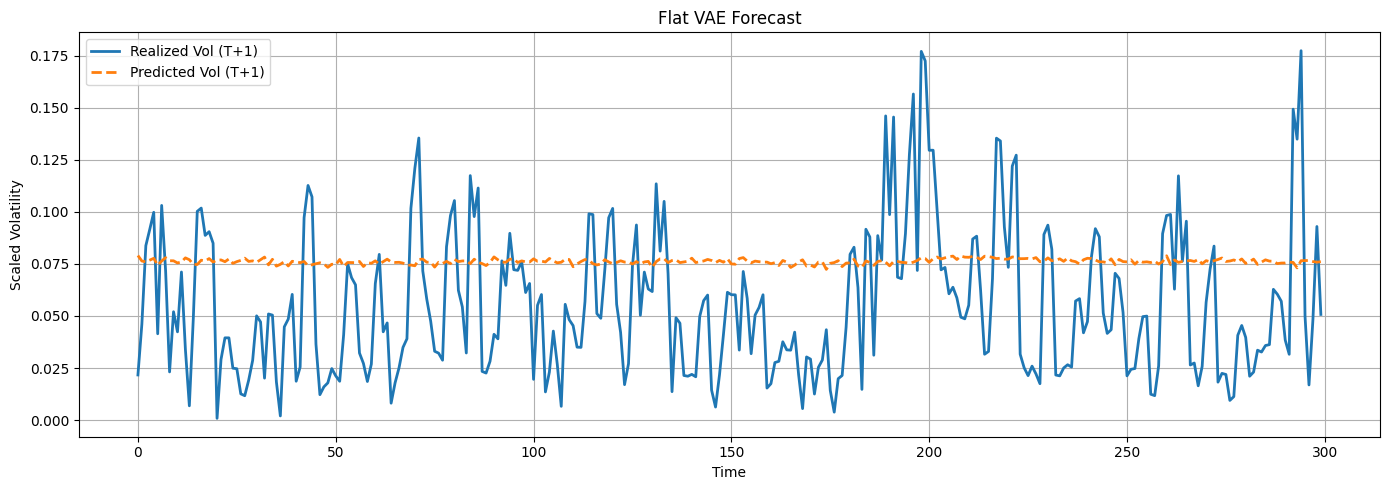

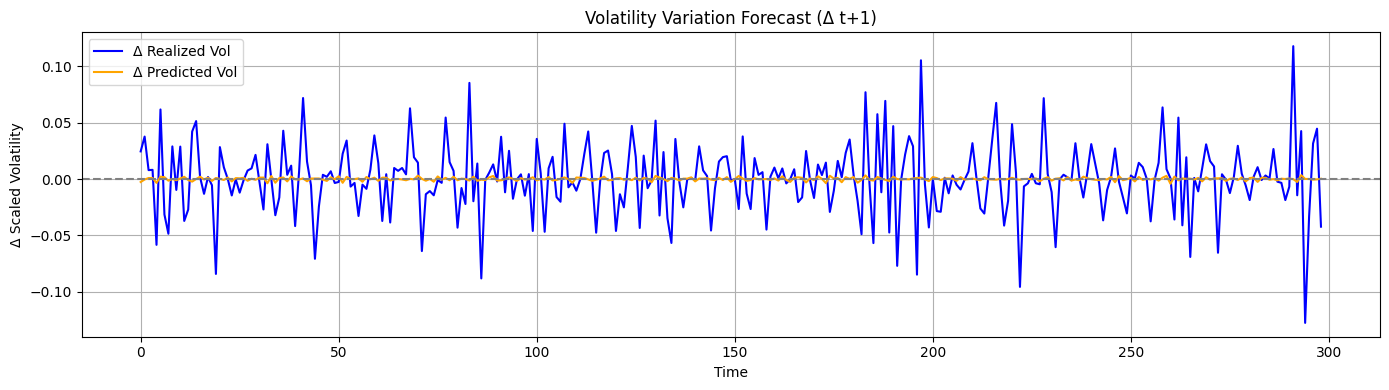

📉 Normalized RMSE:       0.99810
🔗 Pearson Correlation:  0.5562
🔼 Directional Accuracy: 47.63%


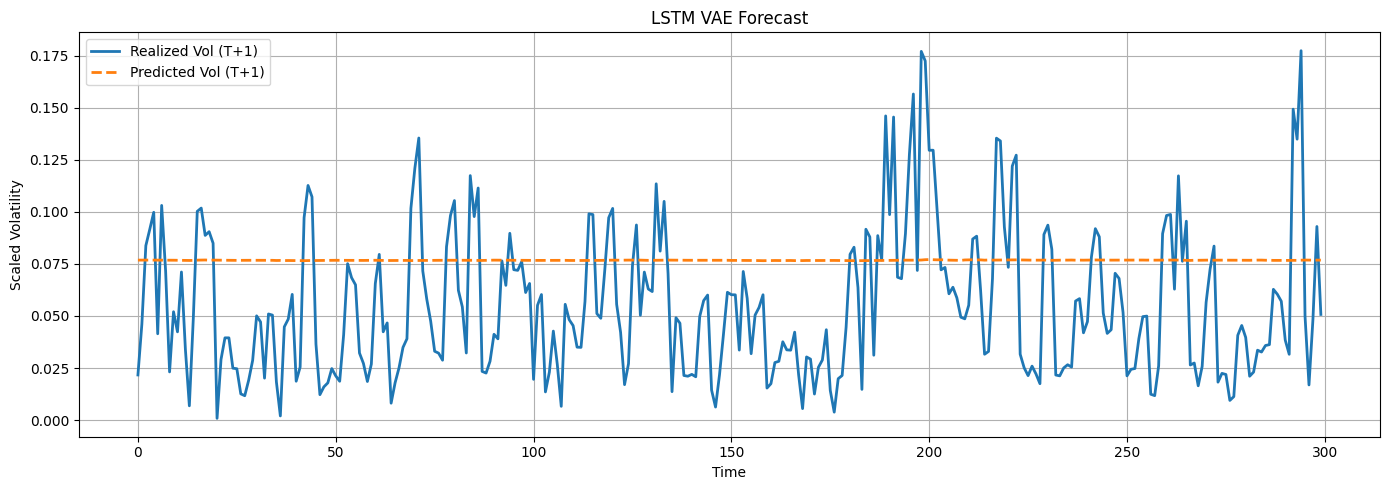

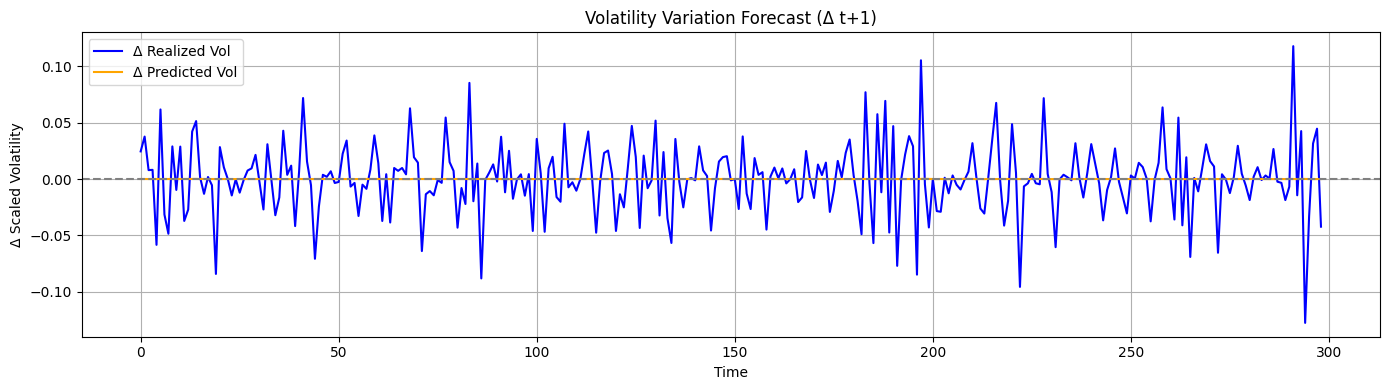

In [17]:
# 1. Extract latent vectors
z_flat, y_flat = extract_latents(vae_flat, test_loader, params['device'])
z_lstm, y_lstm = extract_latents(vae_lstm, test_loader, params['device'])

# 2. Train regression heads
reg_flat = train_latent_regressor(z_flat, y_flat, params['latent_dim'])
reg_lstm = train_latent_regressor(z_lstm, y_lstm, params['latent_dim'])

# 3. Evaluate
evaluate_latent_regressor(reg_flat, z_flat, y_flat, title="Flat VAE Forecast")
evaluate_latent_regressor(reg_lstm, z_lstm, y_lstm, title="LSTM VAE Forecast")


# Part II – Volatility Forecasting with VAE-GRU

Having explored the modeling of volatility regimes through unsupervised learning using LSTM-based Variational Autoencoders (VAE), this second part of the project shifts the focus toward **direct forecasting of future volatility** (e.g., at T+1 or T+3) using a **VAE-GRU architecture**.

---

## Objective

Our aim is now to **predict realized volatility at T+1 (or a future horizon T+n)** directly from past sequences of market features, using a probabilistic model that captures latent structures while leveraging the temporal dynamics of the data.

We explore a more **sequence-to-target** architecture: the encoder ingests past windows (e.g., 20 timesteps), learns a latent representation, and the decoder maps it to a *single scalar volatility forecast*. We move away from pure reconstruction toward **probabilistic supervised forecasting**.

---

## Why GRU?

GRUs (Gated Recurrent Units) offer a simpler and often more stable alternative to LSTMs for sequence encoding. They tend to:
- Require fewer parameters and training time
- Be less prone to overfitting on small sequences
- Capture medium-term dependencies effectively (which is useful for vol windows like 3-day or 5-day rolling std)

This makes GRUs attractive when the goal is to compress recent market movements into a compact latent variable for forecasting.

---

## Theoretical Framework

We adopt a **VAE formulation for time series**, where the **encoder** is a GRU and the **decoder** is a feedforward regressor (or another GRU). The architecture learns to compress historical sequences $ x_{t-N+1:t} $ into a latent variable $ z_t $, and to **predict future volatility** from this latent code.

### Key Formulations

1. **Encoder GRU**:

$$
h_t = \text{GRU}(x_{t-N+1}, \ldots, x_t)
$$
$$
\mu_z, \log\sigma_z = f_{\text{enc}}(h_t)
$$

2. **Reparameterization Trick**:

$$
z_t = \mu_z + \sigma_z \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

3. **Decoder (Forecast Head)**:

$$
\hat{y}_{t+1} = f_{\text{dec}}(z_t)
$$

4. **Loss Function**:

We minimize the standard VAE objective, adapted to time series forecasting:

$$
\mathcal{L} = \mathbb{E}_{q(z|x)}[(y_{t+1} - \hat{y}_{t+1})^2] + \beta \cdot D_{KL}(q(z|x) || p(z))
$$

- The **first term** penalizes inaccurate predictions of future vol.
- The **second term** regularizes the latent space with a KL divergence.

---

## Dataset Construction

We redefine our input/output pairs:

- **Input sequences**: Past windows of size `N` (e.g., 20 timesteps), from features like returns, VIX, rolling vol, etc.
- **Target**: Realized volatility at `T+1` (or `T+3`, depending on experiment).
- Data is scaled and batched identically to Part I for consistency.

---

## Roadmap of Part II

This second part of the notebook will be structured as follows:

1. **Data Reconfiguration**  
   Define new input/output pairs aligned with forecasting volatility directly at T+1 or T+3.

2. **GRU-based VAE Model**  
   Build and explain the architecture: GRU encoder + regressor decoder.

3. **Training Setup**  
   Train on historical sequences using KL-regularized MSE loss.

4. **Evaluation**  
   Compare predictions with realized volatility using correlation, normalized RMSE, and directional accuracy.

5. **Direction-Aware GRU-VAE: Loss Enhancement**  
   Visualize the latent space and interpret market regimes or transitions.

6. **Fourier Loss Integration in VAE-GRU**  

---

This section aims to push the model from an exploratory tool toward an **operational volatility forecaster**, better aligned with real-world use in trading and risk management.


#### **1. Data Reconfiguration**  
####  Forecasting Realized Volatility at T+1 or T+3

In this second phase of the project, we reframe the VAE architecture from an autoencoder of past dynamics into a **probabilistic forecaster**.  
Rather than reconstructing the input sequence, we aim to **learn latent encodings that are predictive of future volatility**.

---

#### New Forecasting Setup

- **Input (`X_seq`)**: sequences of `seq_len = 20` consecutive time steps of past features:  
  $$
  X_t = \{x_{t-19}, x_{t-18}, \dots, x_t\}
  $$

- **Target (`y_vol`)**: realized volatility computed over a short horizon *after* the input window:
  $$
  y_t = \sqrt{ \frac{1}{H} \sum_{i=1}^{H} r_{t+i}^2 }
  $$
  where:
  - $ r_{t+i} $ are the log returns  
  - $ H $ is the forecast horizon (e.g., 1 for T+1, 3 for T+3)

---

#### Key Change from Part 1

| Part 1 (Reconstruction)      | Part 2 (Forecasting)             |
|------------------------------|----------------------------------|
| Decoder reconstructs $ X_t $ | Decoder predicts $ y_{t+H} $     |
| Loss: reconstruction + KL    | Loss: forecast error + KL        |
| Output: full sequence         | Output: scalar volatility forecast |

---

#### Why This Setup?

- The encoder captures **latent regimes of past market conditions**.
- The decoder learns to **forecast realized volatility**, using only the latent representation.
- The structure mirrors real-world tasks:
  - Adjusting position sizes
  - Volatility-based risk filters
  - Hedging decisions

---



### **2. GRU-based VAE Model**  
#### Architecture: GRU Encoder + Regressor Decoder

We now design a **Variational Autoencoder (VAE)** where:

- The **encoder** is a GRU network that learns to **summarize a sequence of market features** into a latent distribution $(\mu, \log \sigma^2)$.
- The **latent space** captures uncertainty and market regimes.
- The **decoder** is a feed-forward regressor that maps latent vectors $ z \sim \mathcal{N}(\mu, \sigma^2) $ to **future volatility estimates**.

#### Architecture Overview

1. **Encoder (GRU):**

$$
x_{1:T} \rightarrow \text{GRU} \rightarrow h_T \rightarrow (\mu, \log\sigma^2)
$$

2. **Latent Sampling:**

$$
z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

3. **Decoder (Regressor):**

$$
z \rightarrow \text{MLP} \rightarrow \hat{y}_{t+H}
$$


#### Loss Function

The total loss is a combination of:
- **Reconstruction loss** (MSE between predicted and true volatility)
- **KL divergence** between the latent distribution and the standard Gaussian prior

$$
\mathcal{L}_{\text{VAE}} = \text{MSE}(\hat{y}, y) + \beta \cdot D_{\text{KL}}\left[q(z|x) \parallel \mathcal{N}(0, I)\right]
$$

---



In [20]:
class VAE_GRU_Volatility(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, latent_dim, beta=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.beta = beta

        #  Encoder  #
        self.encoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        #  Decoder  #
        self.decoder_mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x):
        _, h = self.encoder_rnn(x)          # h: [1, batch, hidden_dim]
        h = h.squeeze(0)                    # [batch, hidden_dim]
        mu = self.mu_layer(h)               # [batch, latent_dim]
        logvar = self.logvar_layer(h)       # [batch, latent_dim]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_mlp(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y_hat = self.decode(z)
        return y_hat, mu, logvar

    def loss_function(self, y_hat, y_true, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = nn.functional.mse_loss(y_hat, y_true, reduction='mean')

        # KL divergence
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Total VAE loss
        return recon_loss + self.beta * kl_div, recon_loss, kl_div



---

#### **3. Training Setup**  
####  Training the GRU-based VAE for Volatility Forecasting

We now train the `VAE_GRU_Volatility` model to **forecast volatility at T+1 (or T+3)** from past market behavior.


#### Training Details

- **Input**: Sequences of shape `(batch_size, seq_len, input_dim)`
- **Target**: Scaled realized volatility at T+H
- **Loss**: Combination of:
  - MSE reconstruction loss
  - KL divergence with $\mathcal{N}(0, I)$
- **Optimizer**: Adam
- **Device**: CPU or GPU (automatically selected)
- **Metrics**: We monitor:
  - Total VAE loss
  - KL divergence
  - MSE (forecast accuracy)

---

In [21]:
def train_gru_vae(model, train_loader, test_loader, n_epochs=50, lr=1e-3, device="cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        train_epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_hat, mu, logvar = model(X_batch)
            loss, recon, kl = model.loss_function(y_hat, y_batch, mu, logvar)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        #  Validation loss  #
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_hat, mu, logvar = model(X_val)
                loss, _, _ = model.loss_function(y_hat, y_val, mu, logvar)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        test_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

    return {"train": train_losses, "val": test_losses}


In [22]:
gru_vae = VAE_GRU_Volatility(
    input_dim=params["input_dim"],
    seq_len=params["seq_len"],
    hidden_dim=params["hidden_dim"],
    latent_dim=params["latent_dim"],
    beta=params["beta"]
)

gru_history = train_gru_vae(
    gru_vae,
    train_loader,
    test_loader,
    n_epochs=params["n_epochs"],
    lr=params["lr"],
    device=params["device"]
)

Epoch 1/50 | Train Loss: 0.0257 | Val Loss: 0.0083
Epoch 2/50 | Train Loss: 0.0093 | Val Loss: 0.0063
Epoch 3/50 | Train Loss: 0.0075 | Val Loss: 0.0054
Epoch 4/50 | Train Loss: 0.0066 | Val Loss: 0.0045
Epoch 5/50 | Train Loss: 0.0057 | Val Loss: 0.0044
Epoch 6/50 | Train Loss: 0.0056 | Val Loss: 0.0039
Epoch 7/50 | Train Loss: 0.0056 | Val Loss: 0.0042
Epoch 8/50 | Train Loss: 0.0054 | Val Loss: 0.0036
Epoch 9/50 | Train Loss: 0.0052 | Val Loss: 0.0038
Epoch 10/50 | Train Loss: 0.0051 | Val Loss: 0.0037
Epoch 11/50 | Train Loss: 0.0052 | Val Loss: 0.0037
Epoch 12/50 | Train Loss: 0.0052 | Val Loss: 0.0038
Epoch 13/50 | Train Loss: 0.0053 | Val Loss: 0.0037
Epoch 14/50 | Train Loss: 0.0051 | Val Loss: 0.0038
Epoch 15/50 | Train Loss: 0.0052 | Val Loss: 0.0039
Epoch 16/50 | Train Loss: 0.0050 | Val Loss: 0.0038
Epoch 17/50 | Train Loss: 0.0052 | Val Loss: 0.0039
Epoch 18/50 | Train Loss: 0.0051 | Val Loss: 0.0034
Epoch 19/50 | Train Loss: 0.0050 | Val Loss: 0.0038
Epoch 20/50 | Train L

Visualize Losses

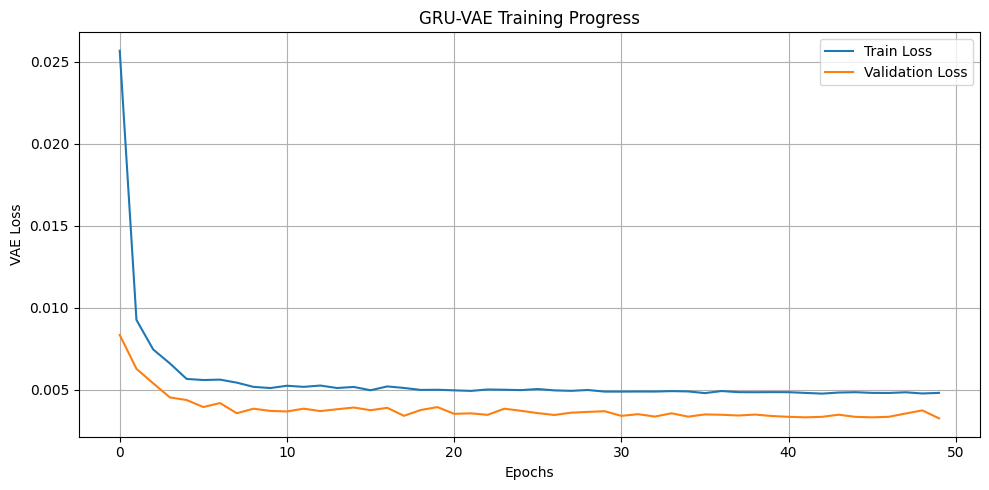

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(gru_history["train"], label="Train Loss")
plt.plot(gru_history["val"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("VAE Loss")
plt.title("GRU-VAE Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **4. Evaluation**  
#### Compare predictions with realized volatility using correlation, normalized RMSE, and directional accuracy

Now that our GRU-based VAE is trained, we evaluate its **forecasting ability** on unseen test data.

We focus on 3 key metrics:

- **Normalized RMSE (NRMSE)**:  
  Measures the model's average error relative to volatility variability  
  $$
  \text{NRMSE} = \frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}}{\text{std}(y)}
  $$

- **Pearson Correlation**:  
  Captures the linear alignment between predicted and actual volatility  
  $$
  \rho(y, \hat{y}) = \frac{\text{Cov}(y, \hat{y})}{\sigma_y \sigma_{\hat{y}}}
  $$

- **Directional Accuracy**:  
  Evaluates if the model correctly predicts the direction of volatility change at T+1:  
  $$
  \text{Accuracy} = \frac{1}{n-1} \sum_{i=2}^{n} \mathbb{1}_{\text{sign}(y_i - y_{i-1}) = \text{sign}(\hat{y}_i - \hat{y}_{i-1})}
  $$

---

In [24]:
from scipy.stats import pearsonr

def evaluate_forecast(model, test_loader, device="cpu", title="GRU-VAE Volatility Forecast"):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat, _, _ = model(X_batch)
            preds.append(y_hat.cpu().numpy())
            true.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds).squeeze()
    true = np.concatenate(true).squeeze()

    #  METRICS  #
    rmse = np.sqrt(np.mean((true - preds)**2))
    nrmse = rmse / np.std(true)
    corr, _ = pearsonr(true, preds)

    # Directional accuracy
    true_diff = np.diff(true)
    pred_diff = np.diff(preds)
    direction_acc = np.mean(np.sign(true_diff) == np.sign(pred_diff))

    #  PRINT  #
    print(f"Normalized RMSE:       {nrmse:.5f}")
    print(f" Pearson Correlation:  {corr:.4f}")
    print(f" Directional Accuracy: {direction_acc*100:.2f}%")

    #  PLOT 1: Forecast vs Realized  #
    plt.figure(figsize=(12, 4))
    plt.plot(true[-300:], label="Realized Vol (T+1)", linewidth=2)
    plt.plot(preds[-300:], label="Predicted Vol (T+1)", linewidth=2, linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Scaled Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  PLOT 2: Directional deltas  #
    plt.figure(figsize=(12, 4))
    plt.plot(true_diff[-300:], label="Δ Realized", color="blue")
    plt.plot(pred_diff[-300:], label="Δ Predicted", color="orange")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Volatility Direction Forecast (Δ T+1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Normalized RMSE:       1.08385
 Pearson Correlation:  0.0575
 Directional Accuracy: 51.15%


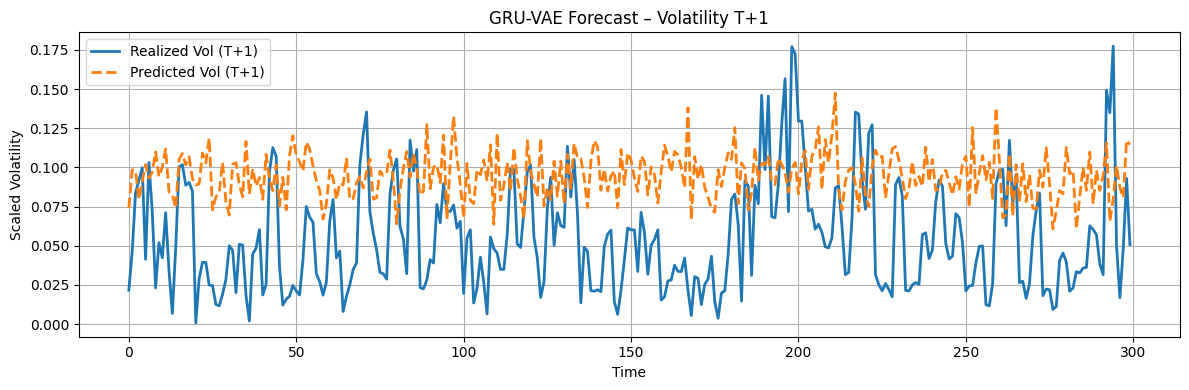

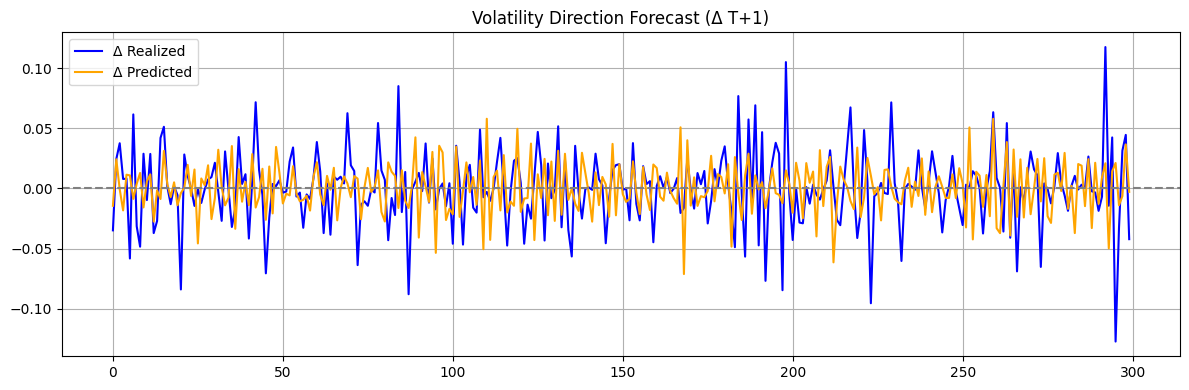

In [ ]:

evaluate_forecast(
    model=gru_vae,              
    test_loader=test_loader,    
    device=params['device'],    
    title="GRU-VAE Forecast – Volatility T+1"
)


###  5 Direction-Aware GRU-VAE: Loss Enhancement

#### Motivation

In volatility forecasting—especially for financial risk metrics like realized volatility at **T+1** —it is often **more valuable to predict the direction of volatility changes** than to estimate the exact value.  
Standard losses such as MSE tend to penalize magnitude errors heavily, even if the **direction** of volatility movement is correct. This is misaligned with practical needs in **risk management, volatility targeting, and hedging**, where understanding whether volatility is going up or down is critical.

We therefore introduce a **hybrid loss** in our GRU-based VAE that:
- Maintains continuous prediction of volatility,
- Adds directional awareness to the objective,
- Balances precision and interpretability.

#### Architecture Recap

We build a standard **VAE (Variational Autoencoder)** with:
- **GRU encoder** that embeds past sequences into a latent space,
- **Latent sampling** with μ and σ²,
- **MLP decoder** to produce the forecasted (scaled) volatility at `T+H`,
- **Auxiliary classification head** to predict the **next directional movement** of volatility.


#### Custom Loss Function

Our full loss combines three terms:

#### 1. Reconstruction Loss (MSE)
We minimize the squared error between predicted and true scaled volatility:

$$
\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

#### 2. KL Divergence  
To regularize the latent space, we include a KL divergence term adapted for **log-normal latent variables**:

We assume the latent variable $z$ follows a **log-normal distribution**, i.e., $z = \exp(\tilde{z})$, with $\tilde{z} \sim \mathcal{N}(\mu, \sigma^2)$.  
The KL divergence between this approximate posterior and the unit log-normal prior becomes:

$$
\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
$$

> *Note*: This is equivalent in form to the standard Gaussian KL divergence, since $z$ is defined in log-space and reparameterized via $\tilde{z}$.

Where:  
- $ \mu_j $, $ \sigma_j^2 $ are the mean and variance of the **log-latent** representation,  
- $ d $ is the latent dimension.


#### 3. Directional Classification Loss (Binary Cross-Entropy)

We define a classification objective for the **direction of volatility** at T+H:

Let:

- $ y_i $ be the true volatility at T+H,
- $ y_{i-1} $ be the realized volatility at T,
- Then the label $ l_i \in \{0, 1\} $ is:

$$
l_i = 
\begin{cases}
1 & \text{if } y_i > y_{i-1} \quad (\text{volatility up}) \\
0 & \text{otherwise} \quad (\text{volatility down or flat})
\end{cases}
$$

Then, the direction loss is:

$$
\mathcal{L}_{\text{dir}} = -\frac{1}{N} \sum_{i=1}^{N} \left[ l_i \log(p_i) + (1 - l_i) \log(1 - p_i) \right]
$$

Where:
- $ p_i = \sigma(\text{logits}_i) $ is the predicted probability (from the decoder head),
- $ \sigma $ is the sigmoid function.

---

#### Final Combined Loss

The total training loss is a **weighted sum** of the three components:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}} + \gamma \cdot \mathcal{L}_{\text{dir}}
$$

Where:
- $ \beta \in [0, 1] $ is the KL scaling parameter,
- $ \gamma \in [0, 1] $ controls the importance of direction classification.

---

#### Results and Impact

By integrating a **direction-aware classification signal** into the loss:
- The model retains high-quality volatility magnitude predictions,
- **Improves directional accuracy**, which is key for trading applications,
- Performs robustly even with scaled features.


In [26]:
import torch
import torch.nn as nn
from scipy.stats import pearsonr
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class VAE_GRU_LogNormal(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, latent_dim, beta=0.2, gamma=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma

        #  Encoder  #
        self.encoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        #  Decoder  #
        self.decoder_mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x):
        _, h = self.encoder_rnn(x)  # h: [1, batch, hidden_dim]
        h = h.squeeze(0)
        mu = self.mu_layer(h)       # mean of log(z)
        logvar = self.logvar_layer(h)  # log-variance of log(z)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Sampling z ~ LogNormal(μ, σ^2) using reparameterization:
        z = exp(μ + σ * ε),  ε ~ N(0,1)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        log_z = mu + eps * std
        return torch.exp(log_z)  # LogNormal sample

    def decode(self, z):
        return self.decoder_mlp(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y_hat = self.decode(z)
        return y_hat, mu, logvar

    def loss_function(self, y_hat, y_true, mu, logvar):
        #  1. Regression (MSE)  #
        recon_loss = nn.functional.mse_loss(y_hat, y_true, reduction='mean')

        #  2. KL divergence between LogNormal(μ, σ²) and LogNormal(0, 1)  #
        # Ref: D_KL(LogNormal(μ, σ²) || LogNormal(0, 1)) = 
        #   0.5 * [ (σ² + μ² - 1 - log(σ²)) ]
        # Note: logvar = log(σ²)

        kl = 0.5 * torch.sum(
            torch.exp(logvar) + mu**2 - 1 - logvar
        ) / mu.size(0)  # mean over batch

        #  3. Directional classification (diff > 0)  #
        with torch.no_grad():
            y_diff = torch.diff(y_true, dim=0)
            y_label = (y_diff > 0).float()

        pred_diff = torch.diff(y_hat, dim=0)
        pred_probs = torch.sigmoid(pred_diff)
        class_loss = nn.functional.binary_cross_entropy(pred_probs, y_label)

        #  4. Final combined loss  #
        total_loss = recon_loss + self.beta * kl + self.gamma * class_loss
        return total_loss, recon_loss, kl, class_loss


def train_gru_vae_directional(model, train_loader, test_loader, n_epochs=50, lr=1e-3, device="cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        train_epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_hat, mu, logvar = model(X_batch)
            loss, recon_loss, kl_loss, class_loss = model.loss_function(y_hat, y_batch, mu, logvar)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        #  Validation 
        model.eval()
        val_epoch_loss = 0.0

        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_hat, mu, logvar = model(X_val)
                loss, _, _, _ = model.loss_function(y_hat, y_val, mu, logvar)
                val_epoch_loss += loss.item()

        val_epoch_loss /= len(test_loader)
        val_losses.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

    return {"train": train_losses, "val": val_losses}


def evaluate_forecast_DA(model, test_loader, device="cpu", title="Direction-Aware GRU-VAE Forecast"):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat, _, _ = model(X_batch)  # only 3 outputs now
            preds.append(y_hat.cpu().numpy())
            true.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds).squeeze()
    true = np.concatenate(true).squeeze()

    #  METRICS  #
    rmse = np.sqrt(np.mean((true - preds)**2))
    nrmse = rmse / np.std(true)
    corr, _ = pearsonr(true, preds)

    # Directional accuracy
    true_diff = np.diff(true)
    pred_diff = np.diff(preds)
    direction_acc = np.mean(np.sign(true_diff) == np.sign(pred_diff))

    #  PRINT  #
    print(f"📊 Normalized RMSE:       {nrmse:.5f}")
    print(f"📈 Pearson Correlation:   {corr:.4f}")
    print(f"🎯 Directional Accuracy:  {direction_acc*100:.2f}%")

    #  PLOT 1: Forecast vs Realized  #
    plt.figure(figsize=(12, 4))
    plt.plot(true[-300:], label="Realized Vol (T+1)", linewidth=2)
    plt.plot(preds[-300:], label="Predicted Vol (T+1)", linewidth=2, linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Scaled Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  PLOT 2: Δ Direction Forecast  #
    plt.figure(figsize=(12, 4))
    plt.plot(true_diff[-300:], label="Δ Realized", color="blue")
    plt.plot(pred_diff[-300:], label="Δ Predicted", color="orange")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Volatility Direction Forecast (Δ T+1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Epoch 1/50 | Train Loss: 0.4556 | Val Loss: 0.4337
Epoch 2/50 | Train Loss: 0.4294 | Val Loss: 0.4257
Epoch 3/50 | Train Loss: 0.4277 | Val Loss: 0.4238
Epoch 4/50 | Train Loss: 0.4248 | Val Loss: 0.4228
Epoch 5/50 | Train Loss: 0.4239 | Val Loss: 0.4228
Epoch 6/50 | Train Loss: 0.4233 | Val Loss: 0.4213
Epoch 7/50 | Train Loss: 0.4230 | Val Loss: 0.4198
Epoch 8/50 | Train Loss: 0.4226 | Val Loss: 0.4205
Epoch 9/50 | Train Loss: 0.4237 | Val Loss: 0.4198
Epoch 10/50 | Train Loss: 0.4232 | Val Loss: 0.4212
Epoch 11/50 | Train Loss: 0.4216 | Val Loss: 0.4200
Epoch 12/50 | Train Loss: 0.4232 | Val Loss: 0.4201
Epoch 13/50 | Train Loss: 0.4225 | Val Loss: 0.4207
Epoch 14/50 | Train Loss: 0.4226 | Val Loss: 0.4188
Epoch 15/50 | Train Loss: 0.4234 | Val Loss: 0.4202
Epoch 16/50 | Train Loss: 0.4225 | Val Loss: 0.4211
Epoch 17/50 | Train Loss: 0.4225 | Val Loss: 0.4206
Epoch 18/50 | Train Loss: 0.4223 | Val Loss: 0.4206
Epoch 19/50 | Train Loss: 0.4222 | Val Loss: 0.4227
Epoch 20/50 | Train L

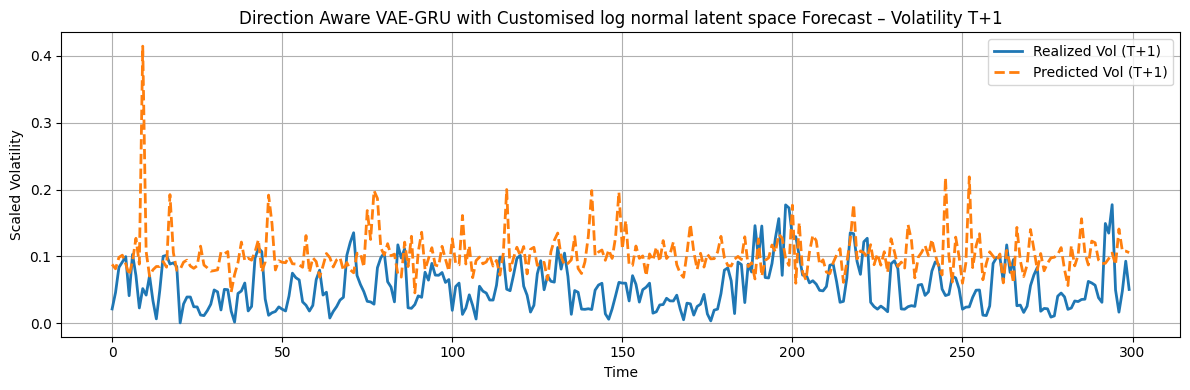

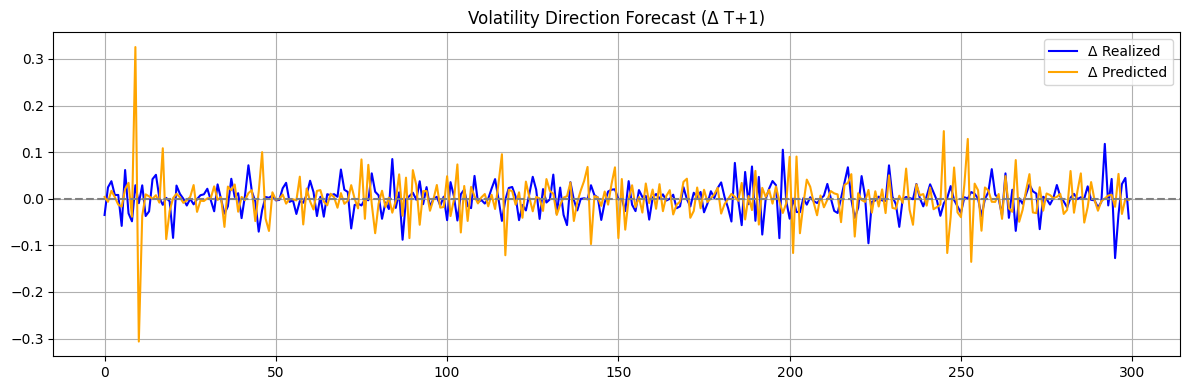

In [27]:
params_V2 = {
    "input_dim": X_scaled.shape[2],
    "seq_len": X_scaled.shape[1],
    "latent_dim": 6,
    "hidden_dim": 64,
    "beta": 0.1,
    "gamma": 0.6,
    "n_epochs": 50,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}


gru_vae_boost = VAE_GRU_LogNormal(
    input_dim=params_V2["input_dim"],
    seq_len=params_V2["seq_len"],
    hidden_dim=params_V2["hidden_dim"],
    latent_dim=params_V2["latent_dim"],
    beta=params_V2["beta"],
    gamma=params_V2["gamma"]
)

gru_history_boost = train_gru_vae_directional(
    model=gru_vae_boost,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=params_V2["n_epochs"],
    lr=params_V2["lr"],
    device=params_V2["device"]
)

evaluate_forecast_DA(
    model=gru_vae_boost,              
    test_loader=test_loader,    
    device=params_V2['device'],    
    title="Direction Aware VAE-GRU with Customised log normal latent space Forecast – Volatility T+1"
)


### 6 Fourier Loss Integration in VAE-GRU

#### Motivation & Transition

To better model the dynamic and irregular nature of volatility—often characterized by sudden spikes and regime shifts—we extend a standard sequential VAE-GRU architecture by incorporating a **Fourier-based spectral loss**. Rather than modifying the model structure, we enrich the **loss function** to penalize discrepancies not just in time domain (via MSE), but also in **frequency domain**, encouraging the model to retain the spectral identity of the true signal.

---

#### Combined Loss Function: Time + Frequency

The total loss combines three components:

$$
\mathcal{L}_{\text{total}} = \underbrace{\text{MSE}(y, \hat{y})}_{\text{Reconstruction}} + \beta \cdot \underbrace{D_{\text{KL}}[q(z|x) \| \mathcal{N}(0, I)]}_{\text{Latent regularization}} + \gamma \cdot \underbrace{\text{MSE}(|\mathcal{F}(y)|,\ |\mathcal{F}(\hat{y})|)}_{\text{Spectral alignment}}
$$

- $ \mathcal{F}(y) $: discrete Fourier transform of the target
- $ |\mathcal{F}(y)| $: amplitude spectrum (modulus)
- $ \gamma $: weight controlling the importance of frequency matching

This **Fourier Loss** helps the model better capture short-term volatility bursts and dynamic regime changes by aligning both the temporal and spectral profiles of predictions.

#### Intuition de la Fourier Loss

The Fourier Loss aims to force the model to reproduce the dominant frequencies of the target time series.

Let $ \mathcal{F}(y) $ be the discrete Fourier transform (DFT) of the series:

$$
\mathcal{F}(y)_k = \sum_{t=0}^{T-1} y_t \cdot e^{-2i\pi kt/T}, \quad k = 0, \dots, T-1
$$

This complex vector encodes information in **frequency and amplitude**. In our case, we focus solely on the **spectral amplitudes**, defined by:

$$
\left| \mathcal{F}(y)_k \right| = \sqrt{ \Re^2( \mathcal{F}(y)_k ) + \Im^2( \mathcal{F}(y)_k ) }
$$

The **Fourier Loss** is therefore an MSE on spectral modules:

$$
\mathcal{L}_{\text{Fourier}} = \text{MSE}\left( \left| \mathcal{F}(y) \right|, \left| \mathcal{F}(\hat{y}) \right| \right)
$$

---

#### Interest in volatility modeling

Volatility shocks, often linked to exogenous events, appear as **high-frequency components** in the spectrum. A simple temporal MSE is often **blind** to these structures, as it minimizes the overall error without capturing the nature of the regimes.

By introducing an **explicit frequency penalty**, Fourier Loss makes it possible to:

- Better capture transient or extreme regimes
- Avoid overly smoothed reconstructions


In [ ]:
class VAE_GRU_Fourier(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, latent_dim, beta=0.2, gamma=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.beta = beta  # KL divergence weight
        self.gamma = gamma  # Fourier loss weight

        #  Encoder 
        self.encoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        #  Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x):
        _, h = self.encoder_rnn(x)
        h = h.squeeze(0)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        y_hat = self.decode(z)
        return y_hat, mu, logvar

    def loss_function(self, y_hat, y_true, mu, logvar):
        #  1. MSE Reconstruction 
        mse_loss = nn.functional.mse_loss(y_hat, y_true)

        #  2. KL Divergence 
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        #  3. Fourier Loss 
        fft_true = torch.fft.fft(y_true.squeeze(), dim=0)
        fft_pred = torch.fft.fft(y_hat.squeeze(), dim=0)

        # Compare amplitudes (magnitudes)
        amp_true = torch.abs(fft_true)
        amp_pred = torch.abs(fft_pred)

        fourier_loss = nn.functional.mse_loss(amp_pred, amp_true)

        #  Total Loss 
        total_loss = mse_loss + self.beta * kl_div + self.gamma * fourier_loss

        return total_loss, mse_loss, kl_div, fourier_loss


Epoch 1/50 | Train Loss: 0.4155 | Val Loss: 0.2247
Epoch 2/50 | Train Loss: 0.2776 | Val Loss: 0.1531
Epoch 3/50 | Train Loss: 0.2511 | Val Loss: 0.1635
Epoch 4/50 | Train Loss: 0.2590 | Val Loss: 0.1868
Epoch 5/50 | Train Loss: 0.2566 | Val Loss: 0.1794
Epoch 6/50 | Train Loss: 0.2505 | Val Loss: 0.1712
Epoch 7/50 | Train Loss: 0.2382 | Val Loss: 0.1517
Epoch 8/50 | Train Loss: 0.2263 | Val Loss: 0.1792
Epoch 9/50 | Train Loss: 0.1948 | Val Loss: 0.1022
Epoch 10/50 | Train Loss: 0.1596 | Val Loss: 0.1188
Epoch 11/50 | Train Loss: 0.1875 | Val Loss: 0.1400
Epoch 12/50 | Train Loss: 0.1604 | Val Loss: 0.0773
Epoch 13/50 | Train Loss: 0.1430 | Val Loss: 0.0815
Epoch 14/50 | Train Loss: 0.1394 | Val Loss: 0.0954
Epoch 15/50 | Train Loss: 0.1262 | Val Loss: 0.1001
Epoch 16/50 | Train Loss: 0.1341 | Val Loss: 0.0832
Epoch 17/50 | Train Loss: 0.1414 | Val Loss: 0.1045
Epoch 18/50 | Train Loss: 0.1443 | Val Loss: 0.0895
Epoch 19/50 | Train Loss: 0.1208 | Val Loss: 0.0933
Epoch 20/50 | Train L

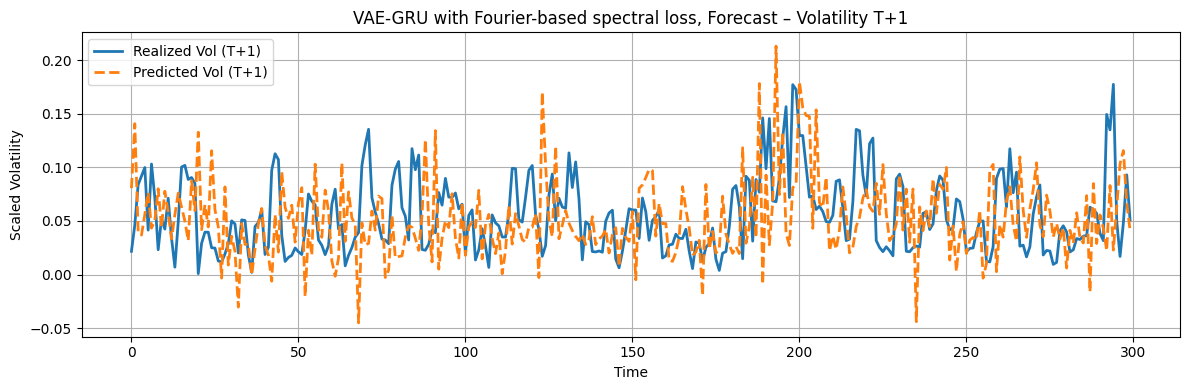

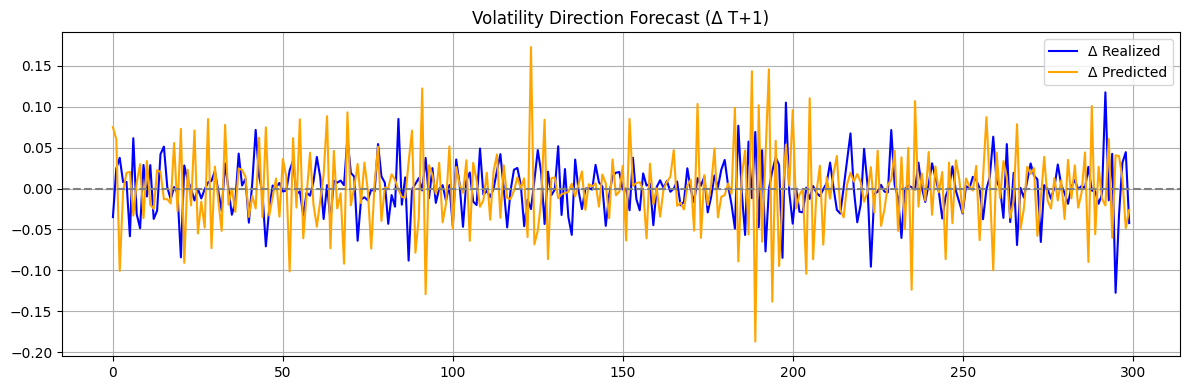

In [28]:
gru_vae_boost = VAE_GRU_Fourier(
    input_dim=params_V2["input_dim"],
    seq_len=params_V2["seq_len"],
    hidden_dim=params_V2["hidden_dim"],
    latent_dim=params_V2["latent_dim"],
    beta=0.3,
    gamma=1
)

gru_history_boost = train_gru_vae_directional(
    model=gru_vae_boost,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=params_V2["n_epochs"],
    lr=params_V2["lr"],
    device=params_V2["device"]
)

evaluate_forecast_DA(
    model=gru_vae_boost,              
    test_loader=test_loader,    
    device=params_V2['device'],    
    title="VAE-GRU with Fourier-based spectral loss, Forecast – Volatility T+1"
)

# Part III - Transformer + MLP for Volatility Forecasting (T+1)

After experimenting with recurrent architectures (GRU, VAE-GRU) and probabilistic modeling (KL-divergence, log-normal latent spaces), we now explore a **pure attention-based architecture** to predict T+1 volatility:

#### Motivation

Volatility is inherently noisy and exhibits both short-term shocks and long-range dependencies. Recurrent models often struggle to capture distant dependencies or quickly adapt to regime changes.

Transformers, on the other hand:
- leverage **self-attention** to focus on relevant parts of the input sequence,
- are **parallelizable** and scale well with data,
- don't rely on recurrence or strict temporal order, making them suitable for irregular or high-frequency signals.

We combine a **Transformer Encoder** with a simple **MLP head** to output the predicted volatility for the next time step.


### Roadmap of Part III 

This third part of the notebook will be structured as follows:

1. **Model Architecture: Transformer for Volatility Forecasting**  
   - Transformer Encoder Layer
   - Temporal Pooling
   - Prediction Head (MLP)

2. **Transformer with fourrier featured loss**  
   - Combination of signal spectrum dynamics (Fourier) and detected peak amplitude     

3. **Transformer with sinusoïdale positional encoding**  
   - Addition of sinusoidal positional encoder 

---
#### 1. Model Architecture: Transformer for Volatility Forecasting

Let the input be a batch of sequences $ \mathbf{X} \in \mathbb{R}^{B \times T \times d} $, where:
- $ B $: batch size
- $ T $: sequence length (lookback window)
- $ d $: number of input features

- 1. Linear Projection to Model Dimension
The raw input features are first projected to the model dimension:
$$
\mathbf{H}_0 = \mathbf{X} \cdot \mathbf{W}_{\text{proj}} + \mathbf{b}_{\text{proj}} \in \mathbb{R}^{B \times T \times d_{\text{model}}}
$$

- 2. Positional Encoding
To encode temporal order (since attention is permutation-invariant), we add a **positional encoding** matrix $ \mathbf{P} \in \mathbb{R}^{T \times d_{\text{model}}} $ to each input:
- **Learned** version (ours): $ \mathbf{P} $ is a parameter trained jointly with the model
- **Sinusoidal** version (Vaswani et al. 2017):
$$
\mathbf{P}_{t, 2i} = \sin\left(\frac{t}{10000^{2i/d_{\text{model}}}} \right), \quad
\mathbf{P}_{t, 2i+1} = \cos\left(\frac{t}{10000^{2i/d_{\text{model}}}} \right)
$$

Final input to attention layer:
$$
\tilde{\mathbf{H}}_0 = \mathbf{H}_0 + \mathbf{P}
$$

#### Transformer Encoder Layer

Each encoder layer applies **multi-head self-attention** followed by a feed-forward network.

**Self-Attention**

We first project each timestep into:
- Queries: $ \mathbf{Q} = \tilde{\mathbf{H}}_0 \cdot \mathbf{W}_Q $
- Keys: $ \mathbf{K} = \tilde{\mathbf{H}}_0 \cdot \mathbf{W}_K $
- Values: $ \mathbf{V} = \tilde{\mathbf{H}}_0 \cdot \mathbf{W}_V $

Self-attention weights:
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left( \frac{\mathbf{QK}^\top}{\sqrt{d_k}} \right)\mathbf{V}
$$

**Multi-Head Attention**

Instead of using a single attention mechanism, we split the model dimension into $ h $ heads:
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) \cdot W^O
$$

Each head attends to different subspaces:
$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

**Feed-Forward Network**

A position-wise fully connected layer:
$$
\text{FFN}(x) = \text{ReLU}(x W_1 + b_1) W_2 + b_2
$$

With residual connections and layer normalization after each block.

#### Temporal Pooling
After $ L $ stacked encoder layers, we obtain contextualized embeddings $ \mathbf{H}_L \in \mathbb{R}^{B \times T \times d_{\text{model}}} $. We aggregate over time:
$$
\bar{\mathbf{h}} = \frac{1}{T} \sum_{t=1}^T \mathbf{H}_L[:, t, :]
$$
(Alternative: use the embedding from the last time step)

#### Prediction Head (MLP)
Final prediction for volatility $ \hat{y} \in \mathbb{R}^{B \times 1} $:
$$
\hat{y} = \text{MLP}(\bar{\mathbf{h}}) = W_2 \cdot \text{ReLU}(W_1 \cdot \bar{\mathbf{h}} + b_1) + b_2
$$


In [29]:
import torch
import torch.nn as nn


class VolatilityTransformer(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=64, nhead=4, num_layers=2, mlp_hidden=64):
        super().__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim

        # Project input features to model dimension
        self.input_proj = nn.Linear(input_dim, d_model)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(seq_len, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # MLP regression head
        self.mlp_head = nn.Sequential(
            nn.Linear(d_model, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1)
        )

    def forward(self, x):
        # x : [batch_size, seq_len, input_dim]
        batch_size, seq_len, input_dim = x.shape
        assert seq_len == self.seq_len, f"Expected seq_len={self.seq_len}, got {seq_len}"

        x = self.input_proj(x)  # [batch_size, seq_len, d_model]
        x = x + self.positional_encoding.unsqueeze(0)  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x_pooled = x.mean(dim=1)  # Global average pooling
        return self.mlp_head(x_pooled)  # [batch_size, 1]


class AmplifiedMSELoss(nn.Module):
    def __init__(self, alpha=2.0):
        super().__init__()
        self.alpha = alpha  # Intensité du poids des pics

    def forward(self, y_pred, y_true):
        weights = 1 + self.alpha * (y_true - y_true.mean()).abs()
        loss = ((y_pred - y_true) ** 2 * weights).mean()
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=0.5):
        super().__init__()
        self.alpha = alpha  # Poids des pics
        self.gamma = gamma  # Poids Fourier

    def forward(self, y_pred, y_true):
        # Amplification des pics
        weights = 1 + self.alpha * (y_true - y_true.mean()).abs()
        mse_weighted = ((y_pred - y_true) ** 2 * weights).mean()

        # Fourier Loss
        fft_true = torch.fft.fft(y_true.squeeze(), dim=0)
        fft_pred = torch.fft.fft(y_pred.squeeze(), dim=0)
        amp_true = torch.abs(fft_true)
        amp_pred = torch.abs(fft_pred)
        fourier = nn.functional.mse_loss(amp_pred, amp_true)

        return mse_weighted + self.gamma * fourier


def train_transformer_model(model, train_loader, test_loader, n_epochs=50, lr=1e-3, alpha=2.0, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = AmplifiedMSELoss(alpha=alpha)

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        #  Validation  #
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)
                val_loss += loss.item()

        test_loss = val_loss / len(test_loader)
        test_losses.append(test_loss)

        print(f"[{epoch+1}/{n_epochs}] Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

    return {
        "train_loss": train_losses,
        "test_loss": test_losses
    }



def evaluate_forecast_transformer_MPL(model, test_loader, device="cpu", title="Transformer Forecast – Volatility T+1"):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat = model(X_batch)
            preds.append(y_hat.cpu().numpy())
            true.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds).squeeze()
    true = np.concatenate(true).squeeze()

    #  METRICS  #
    rmse = np.sqrt(np.mean((true - preds)**2))
    nrmse = rmse / np.std(true)
    corr, _ = pearsonr(true, preds)

    # Directional accuracy
    true_diff = np.diff(true)
    pred_diff = np.diff(preds)
    direction_acc = np.mean(np.sign(true_diff) == np.sign(pred_diff))

    #  PRINT  #
    print(f"Normalized RMSE:       {nrmse:.5f}")
    print(f" Pearson Correlation:  {corr:.4f}")
    print(f" Directional Accuracy: {direction_acc*100:.2f}%")

    #  PLOT 1: Forecast vs Realized  #
    plt.figure(figsize=(12, 4))
    plt.plot(true[-300:], label="Realized Vol (T+1)", linewidth=2)
    plt.plot(preds[-300:], label="Predicted Vol (T+1)", linewidth=2, linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Scaled Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  PLOT 2: Directional deltas  #
    plt.figure(figsize=(12, 4))
    plt.plot(true_diff[-300:], label="Δ Realized", color="blue")
    plt.plot(pred_diff[-300:], label="Δ Predicted", color="orange")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Volatility Direction Forecast (Δ T+1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




[1/80] Train Loss: 0.068705 | Test Loss: 0.009604
[2/80] Train Loss: 0.017347 | Test Loss: 0.004734
[3/80] Train Loss: 0.017781 | Test Loss: 0.004691
[4/80] Train Loss: 0.017843 | Test Loss: 0.004685
[5/80] Train Loss: 0.017814 | Test Loss: 0.004701
[6/80] Train Loss: 0.017838 | Test Loss: 0.004788
[7/80] Train Loss: 0.017870 | Test Loss: 0.004983
[8/80] Train Loss: 0.017788 | Test Loss: 0.005136
[9/80] Train Loss: 0.017756 | Test Loss: 0.004983
[10/80] Train Loss: 0.017831 | Test Loss: 0.004851
[11/80] Train Loss: 0.017898 | Test Loss: 0.004796
[12/80] Train Loss: 0.017938 | Test Loss: 0.004794
[13/80] Train Loss: 0.017909 | Test Loss: 0.004821
[14/80] Train Loss: 0.017877 | Test Loss: 0.004850
[15/80] Train Loss: 0.017903 | Test Loss: 0.004884
[16/80] Train Loss: 0.017878 | Test Loss: 0.004857
[17/80] Train Loss: 0.017862 | Test Loss: 0.004814
[18/80] Train Loss: 0.017904 | Test Loss: 0.004779
[19/80] Train Loss: 0.017941 | Test Loss: 0.004776
[20/80] Train Loss: 0.017932 | Test Loss

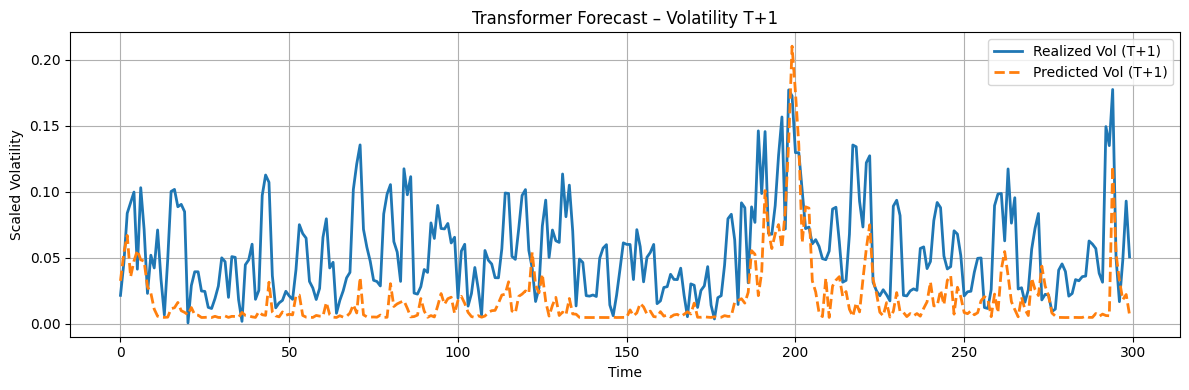

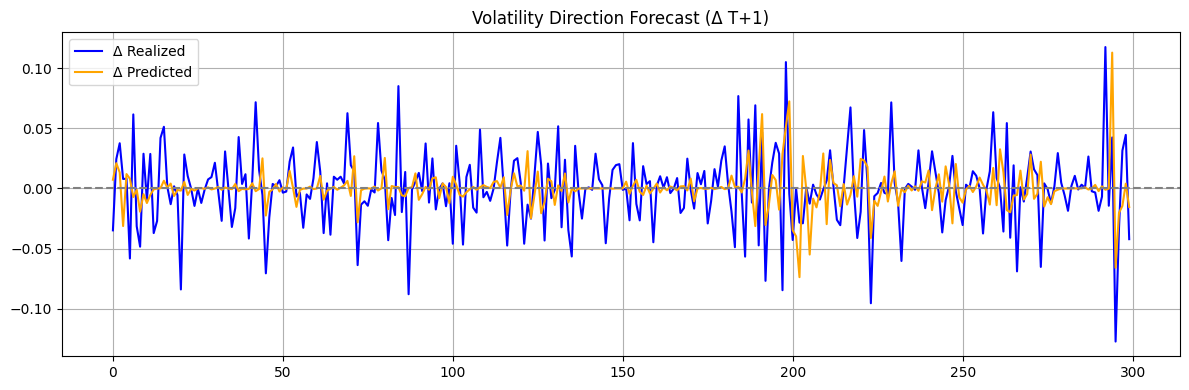

In [30]:
transformer_Vol = VolatilityTransformer(
    input_dim=params_V2["input_dim"],
    seq_len=20,
    d_model=64,     #64       
    nhead=32,        #32
    num_layers=2,    #2
    mlp_hidden=3     #3
)

history = train_transformer_model(
    model=transformer_Vol,
    train_loader=train_loader,
    alpha= 10.0, 
    test_loader=test_loader,
    n_epochs=80,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

evaluate_forecast_transformer_MPL(
    model=transformer_Vol,
    test_loader=test_loader,
    device=params["device"],
    title="Transformer Forecast – Volatility T+1"
)

### Transformer with fourrier featured loss 

[1/50] Train Loss: 0.367197 | Test Loss: 0.087075
[2/50] Train Loss: 0.153949 | Test Loss: 0.093775
[3/50] Train Loss: 0.154381 | Test Loss: 0.092596
[4/50] Train Loss: 0.154238 | Test Loss: 0.092822
[5/50] Train Loss: 0.154262 | Test Loss: 0.092748
[6/50] Train Loss: 0.154276 | Test Loss: 0.092590
[7/50] Train Loss: 0.153876 | Test Loss: 0.092292
[8/50] Train Loss: 0.153902 | Test Loss: 0.092106
[9/50] Train Loss: 0.153576 | Test Loss: 0.091922
[10/50] Train Loss: 0.153576 | Test Loss: 0.091410
[11/50] Train Loss: 0.153840 | Test Loss: 0.091338
[12/50] Train Loss: 0.153224 | Test Loss: 0.091076
[13/50] Train Loss: 0.153385 | Test Loss: 0.090747
[14/50] Train Loss: 0.152987 | Test Loss: 0.090785
[15/50] Train Loss: 0.152891 | Test Loss: 0.090367
[16/50] Train Loss: 0.152091 | Test Loss: 0.089591
[17/50] Train Loss: 0.151787 | Test Loss: 0.088748
[18/50] Train Loss: 0.149397 | Test Loss: 0.085636
[19/50] Train Loss: 0.141887 | Test Loss: 0.063746
[20/50] Train Loss: 0.106075 | Test Loss

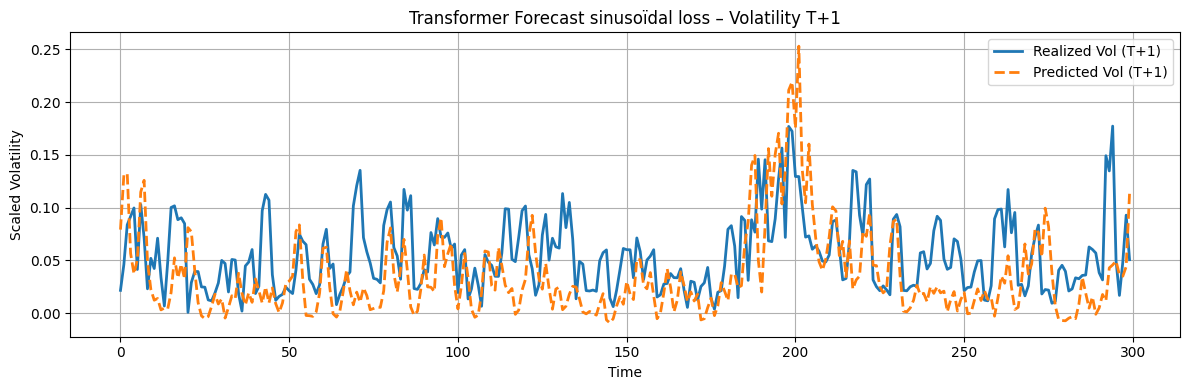

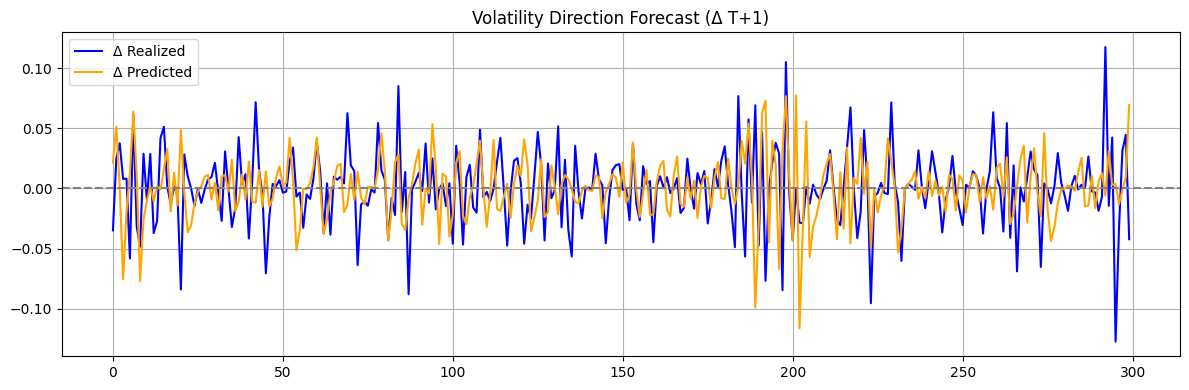

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=0.5):
        super().__init__()
        self.alpha = alpha  # Poids des pics
        self.gamma = gamma  # Poids Fourier

    def forward(self, y_pred, y_true):
        # Amplification des pics
        weights = 1 + self.alpha * (y_true - y_true.mean()).abs()
        mse_weighted = ((y_pred - y_true) ** 2 * weights).mean()

        # Fourier Loss
        fft_true = torch.fft.fft(y_true.squeeze(), dim=0)
        fft_pred = torch.fft.fft(y_pred.squeeze(), dim=0)
        amp_true = torch.abs(fft_true)
        amp_pred = torch.abs(fft_pred)
        fourier = nn.functional.mse_loss(amp_pred, amp_true)

        return mse_weighted + self.gamma * fourier


def train_transformer_model_v2(model, train_loader, test_loader, n_epochs=50, lr=1e-3, alpha=2.0, gamma=1.0, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, gamma=gamma)

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        #  Validation  #
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)
                val_loss += loss.item()

        test_loss = val_loss / len(test_loader)
        test_losses.append(test_loss)

        print(f"[{epoch+1}/{n_epochs}] Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

    return {
        "train_loss": train_losses,
        "test_loss": test_losses
    }

transformer_Vol = VolatilityTransformer(
    input_dim=params_V2["input_dim"],
    seq_len=20,
    d_model=64,     #64        
    nhead=32,       #32
    num_layers=2,   #2
    mlp_hidden=3    #3
)

history = train_transformer_model_v2(
    model=transformer_Vol,
    train_loader=train_loader,
    alpha= 5.0,    #5.0
    gamma=0.5,      #0.5
    test_loader=test_loader,
    n_epochs=50,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

evaluate_forecast_transformer_MPL(
    model=transformer_Vol,
    test_loader=test_loader,
    device=params["device"],
    title="Transformer Forecast sinusoïdal loss – Volatility T+1"
)

### Transformer with sinusoïdale positional encoding 

[1/50] Train Loss: 0.053135 | Test Loss: 0.005421
[2/50] Train Loss: 0.017807 | Test Loss: 0.006540
[3/50] Train Loss: 0.017673 | Test Loss: 0.006135
[4/50] Train Loss: 0.017546 | Test Loss: 0.005967
[5/50] Train Loss: 0.017508 | Test Loss: 0.005560
[6/50] Train Loss: 0.017331 | Test Loss: 0.005682
[7/50] Train Loss: 0.017473 | Test Loss: 0.005721
[8/50] Train Loss: 0.017468 | Test Loss: 0.006309
[9/50] Train Loss: 0.017680 | Test Loss: 0.006350
[10/50] Train Loss: 0.017618 | Test Loss: 0.006442
[11/50] Train Loss: 0.017584 | Test Loss: 0.005659
[12/50] Train Loss: 0.017311 | Test Loss: 0.005658
[13/50] Train Loss: 0.017356 | Test Loss: 0.005653
[14/50] Train Loss: 0.017384 | Test Loss: 0.005675
[15/50] Train Loss: 0.017357 | Test Loss: 0.005673
[16/50] Train Loss: 0.017365 | Test Loss: 0.005758
[17/50] Train Loss: 0.017387 | Test Loss: 0.005777
[18/50] Train Loss: 0.017406 | Test Loss: 0.006501
[19/50] Train Loss: 0.017642 | Test Loss: 0.006264
[20/50] Train Loss: 0.017564 | Test Loss

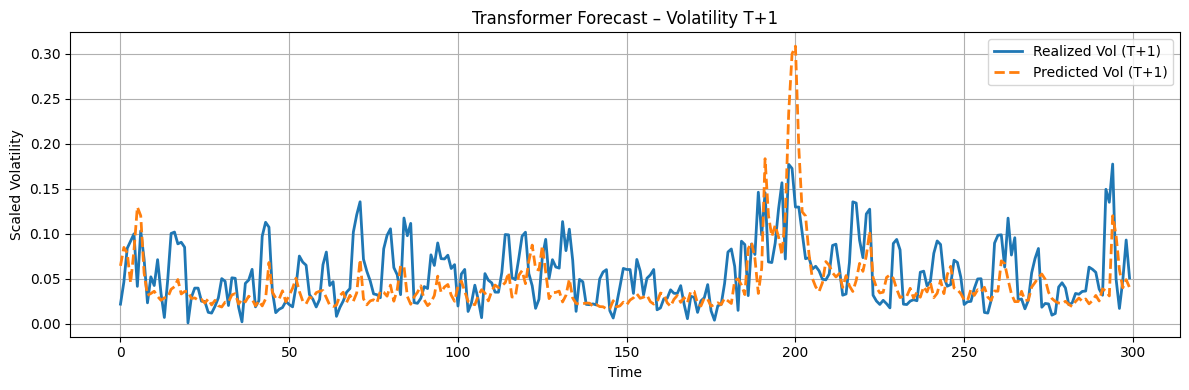

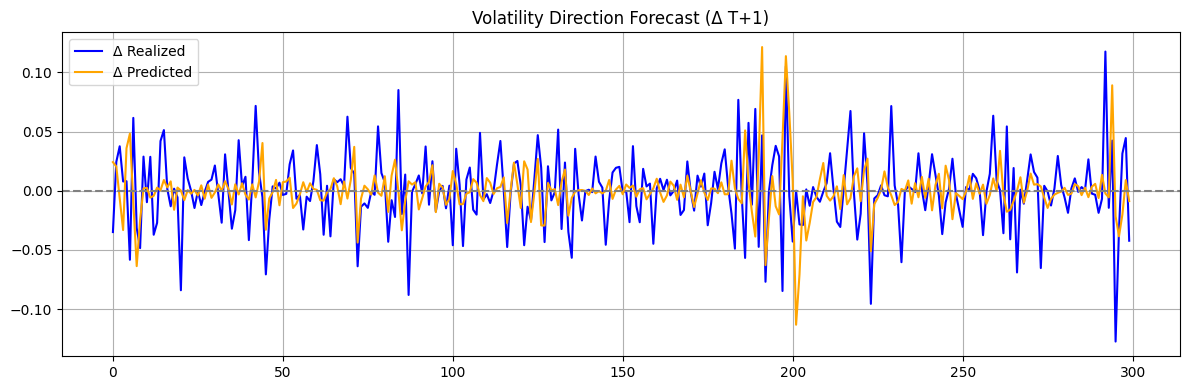

In [38]:
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()

        position = torch.arange(seq_len).unsqueeze(1)  # [seq_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # [d_model//2]

        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # dim pair (even)
        pe[:, 1::2] = torch.cos(position * div_term)  # dim impair (odd)

        self.register_buffer("pe", pe)  # Pas un paramètre entraînable

    def forward(self, x):
        return x + self.pe.unsqueeze(0)  # [1, seq_len, d_model]


class VolatilityTransformer_sin(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=64, nhead=4, num_layers=2, mlp_hidden=64):
        super().__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim

        # Project input features to model dimension
        self.input_proj = nn.Linear(input_dim, d_model)

        # Learnable positional encoding
        self.positional_encoding = SinusoidalPositionalEncoding(seq_len, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # MLP regression head
        self.mlp_head = nn.Sequential(
            nn.Linear(d_model, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1)
        )

    def forward(self, x):
        # x : [batch_size, seq_len, input_dim]
        batch_size, seq_len, input_dim = x.shape
        assert seq_len == self.seq_len, f"Expected seq_len={self.seq_len}, got {seq_len}"

        x = self.input_proj(x)  # [batch_size, seq_len, d_model]
        x = x + self.positional_encoding(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x_pooled = x.mean(dim=1)  # Global average pooling
        return self.mlp_head(x_pooled)  # [batch_size, 1]


transformer_Vol = VolatilityTransformer_sin(
    input_dim=params_V2["input_dim"],
    seq_len=20,
    d_model=32,            
    nhead=16,
    num_layers=2,
    mlp_hidden=3
)

history = train_transformer_model(
    model=transformer_Vol,
    train_loader=train_loader,
    alpha= 10.0, 
    test_loader=test_loader,
    n_epochs=50,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

evaluate_forecast_transformer_MPL(
    model=transformer_Vol,
    test_loader=test_loader,
    device=params["device"],
    title="Transformer Forecast – Volatility T+1"
)